## Final Machine Learning Project

866053 Falanga Davide  
879254 Spagnolo Andrea

Dataset:   
Heart Failure Prediction Dataset (https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data)

EDA:  
* General and detailed charts
* PCA  

Models:  
* DecisionTree
* SVM
* NeuralNetwork




In [44]:
%pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

import warnings

warnings.filterwarnings('ignore')

In [46]:
# Importa il dataset da github
#path_dataset = '/content/drive/MyDrive/mlproject/heart.csv'
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploration Data Analysis


In [47]:
# Descrizione delle feature numeriche
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [48]:
# Informazioni generali sulla composizione del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The dataset has no null values.

#### Data Cleaning

In [49]:
# Rimuovi duplicati
df.drop_duplicates(inplace=True)

print('# of final instances:', df.shape[0])


# of final instances: 918


In [50]:
df.select_dtypes(include='object').nunique()

Sex               2
ChestPainType     4
RestingECG        3
ExerciseAngina    2
ST_Slope          3
dtype: int64

Few unique values for each categorical feature
-> Might be handled with a OneHotEncoder

In [51]:
# Conversione delle feature categoriche binarie in booleani
df['HeartDisease'] = df['HeartDisease'].astype(bool)

# Conversione delle feature categoriche binarie in numerici (0/1)
df['Sex'] = pd.Categorical(df['Sex'].map({'M': 1, 'F': 0}), categories=[0, 1])
df['ExerciseAngina'] = pd.Categorical(df['ExerciseAngina'].map({'Y': 1, 'N': 0}), categories=[0, 1])
df['FastingBS'] = pd.Categorical(df['FastingBS'], categories=[0, 1])

# Le feature binarie sono già pronte per essere usate, le mettiamo in una lista
bin_features = ['Sex', 'FastingBS', 'ExerciseAngina']

# Lista delle feature categoriche da modificare con one-hot-encoder
cat_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

# Lista delle feature numeriche
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Converte solo le feature categoriche multiple in 'category'
df[cat_features] = df[cat_features].astype('category')

# One-hot encoding
one_hot = OneHotEncoder(sparse_output=False)
encoded_array = one_hot.fit_transform(df[cat_features])

# Crea un dataframe con le feature categoriche codificate
encoded_df = pd.DataFrame(encoded_array,
                          columns=one_hot.get_feature_names_out(cat_features),
                          index=df.index)

# Crea un nuovo dataset rimuovendo le colonne categoriche originali
df_clean = pd.concat([df.drop(columns=cat_features), encoded_df], axis=1)

In [52]:
df_clean.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


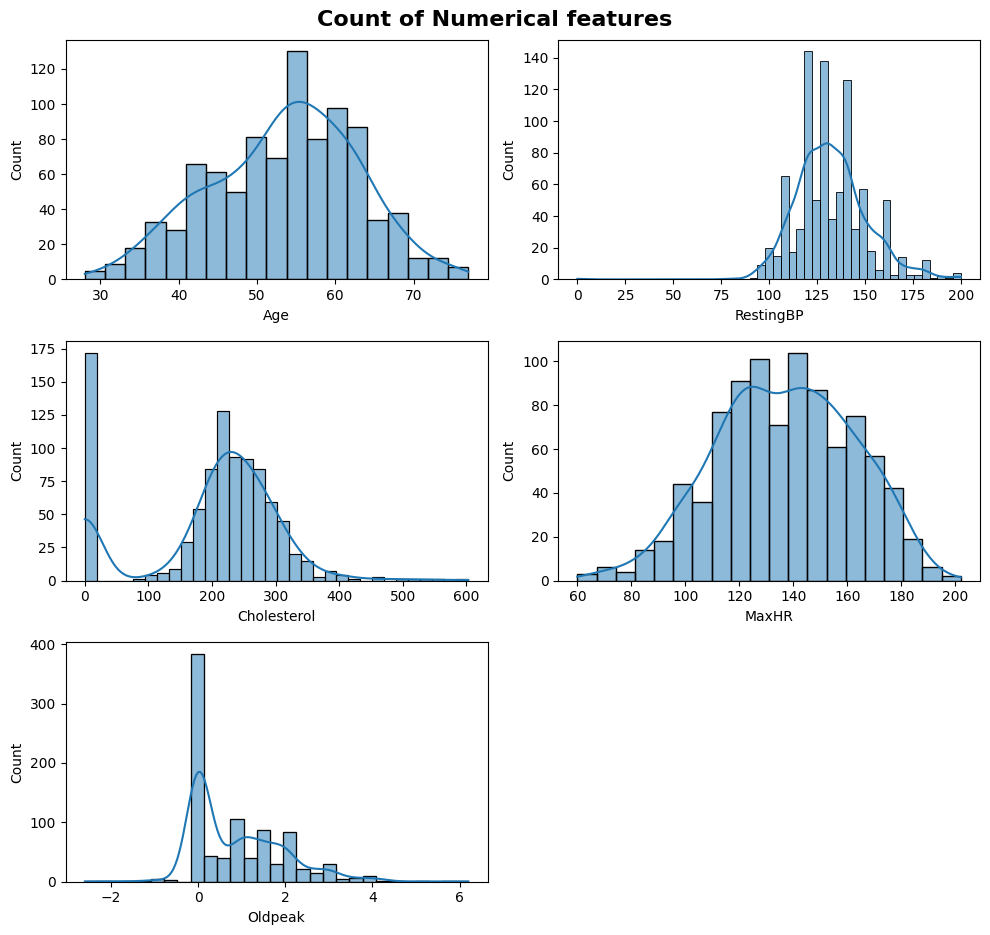

In [53]:
# Crea subplot delle distribuzioni delle feature numeriche
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Count of Numerical features', fontsize=16, weight='bold', y=0.93)

for i in num_features:
    ax = plt.subplot(3,2,num_features.index(i)+1)
    sns.histplot(df[i], kde=True)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [54]:
# calcolo percentuale di valori mancanti in Cholesterol
zero_cholesterol_count = (df['Cholesterol'] == 0).sum()
print(f"percentage of 0 in Cholesterol : {(zero_cholesterol_count/len(df['Cholesterol']))*100:.2f}%")


percentage of 0 in Cholesterol : 18.74%


In [55]:
# Gestione dei valori mancanti in Cholesterol
mean_cholesterol = df.loc[df['Cholesterol'] != 0, 'Cholesterol'].mean()

df['Cholesterol'] = df['Cholesterol'].replace(0, mean_cholesterol)
df_clean['Cholesterol'] = df['Cholesterol']

In [56]:
# Calcola kurtosis e skewness delle distribuzioni di feature numeriche
print("Valori di Kurtosis (punta accentuata) e Skewness (asimmetria) delle distribuzioni delle features numeriche:\n")
df[num_features].agg(['kurtosis', 'skew'])

Valori di Kurtosis (punta accentuata) e Skewness (asimmetria) delle distribuzioni delle features numeriche:



,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
kurtosis,-0.386140,3.271251,6.257803,-0.448248,1.203064
skew,-0.195933,0.179839,1.373396,-0.144359,1.022872


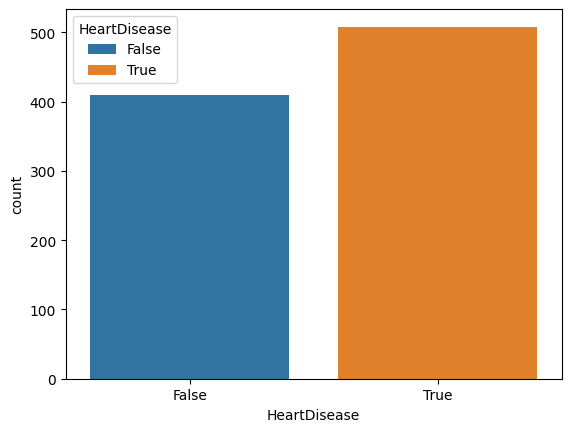

HeartDisease
True     55.34%
False    44.66%
Name: proportion, dtype: object


In [57]:
# Distribuzione del target
sns.countplot(x=df['HeartDisease'], hue=df['HeartDisease'])
plt.show()

# Calcola le percentuali della variabile target
percentuali = (df['HeartDisease'].value_counts(normalize=True) * 100).round(2).astype(str) + '%'
print(percentuali)


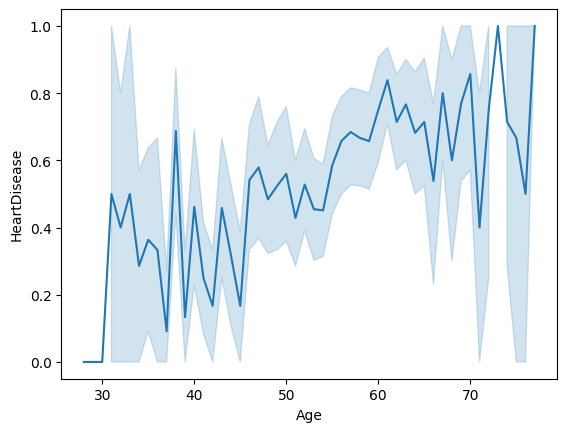

In [58]:
# Correlazione tra età e target
sns.lineplot(x='Age', y='HeartDisease', data=df)
plt.show()

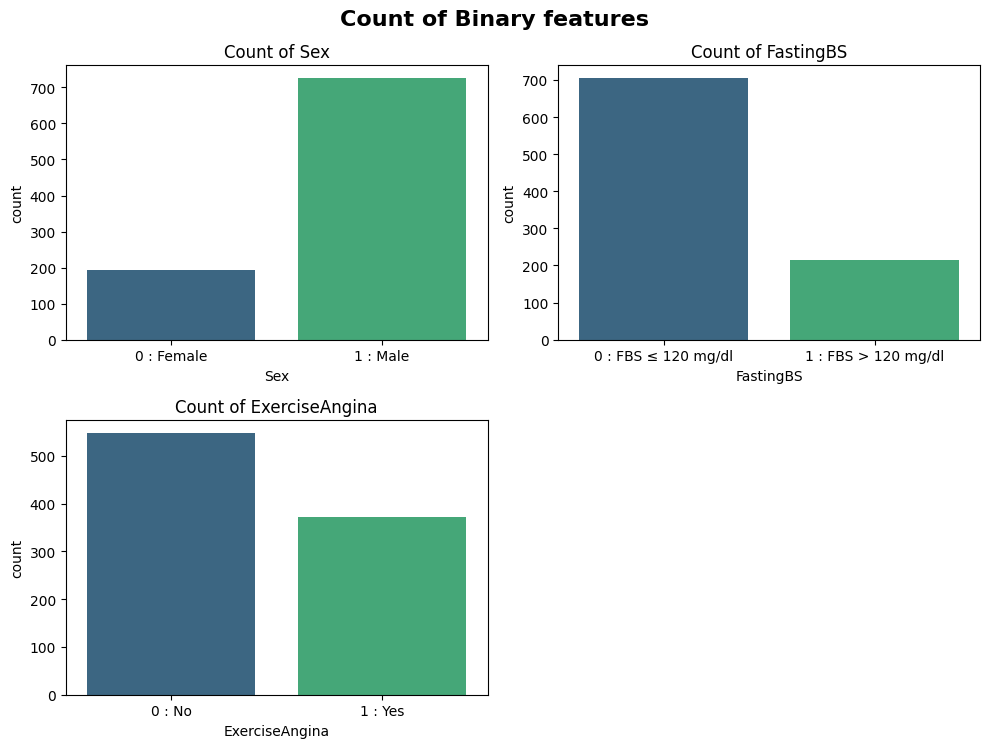

In [59]:
# Plot della distribuzione delle feature booleane/binarie
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Count of Binary features', fontsize=16, weight='bold', y=0.93)

# Dizionario per le etichette descrittive
labels_dict = {
    'Sex': {0: '0 : Female', 1: '1 : Male'},
    'FastingBS': {0: '0 : FBS ≤ 120 mg/dl', 1: '1 : FBS > 120 mg/dl'},
    'ExerciseAngina': {0: '0 : No', 1: '1 : Yes'}
}

for i, feature in enumerate(bin_features):
    ax = plt.subplot(2, 2, i+1)
    ax.set_title(f'Count of {feature}')
    
    # Crea il countplot
    sns.countplot(x=feature, data=df, palette='viridis', ax=ax)
    
    # Modifica le etichette dell'asse x con le descrizioni
    if feature in labels_dict:
        ax.set_xticklabels([labels_dict[feature][int(label.get_text())] 
                           for label in ax.get_xticklabels()])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

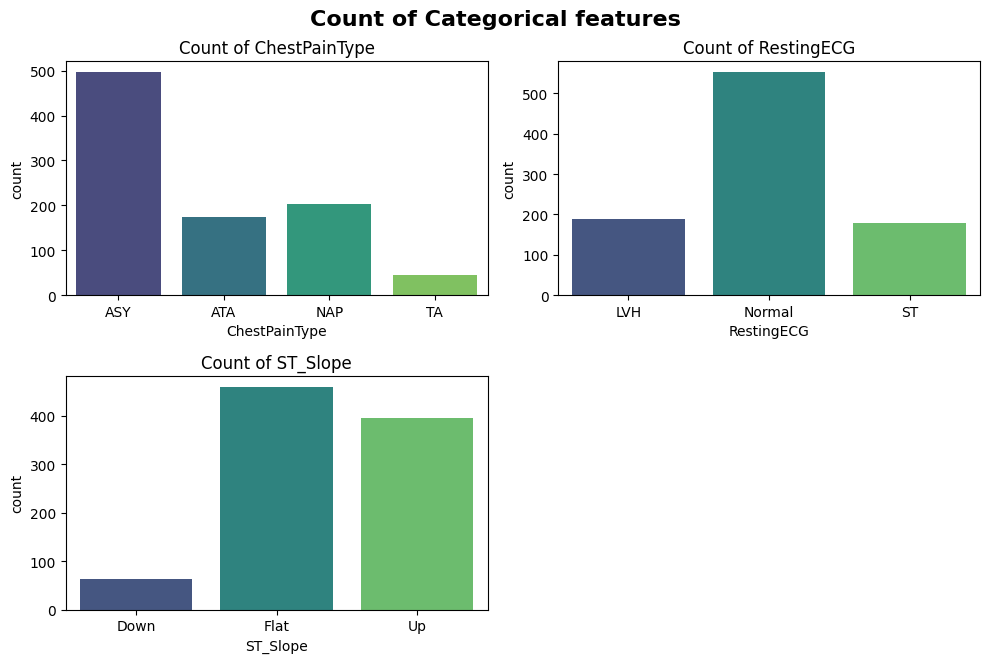

In [60]:
# Plot della distribuzione delle feature categoriche
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Count of Categorical features', fontsize=16, weight='bold', y=0.93)

for i in cat_features:
    ax = plt.subplot(3,2,cat_features.index(i)+1)
    ax.set_title(f'Count of {i}')
    sns.countplot(x=i, data=df, palette='viridis')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

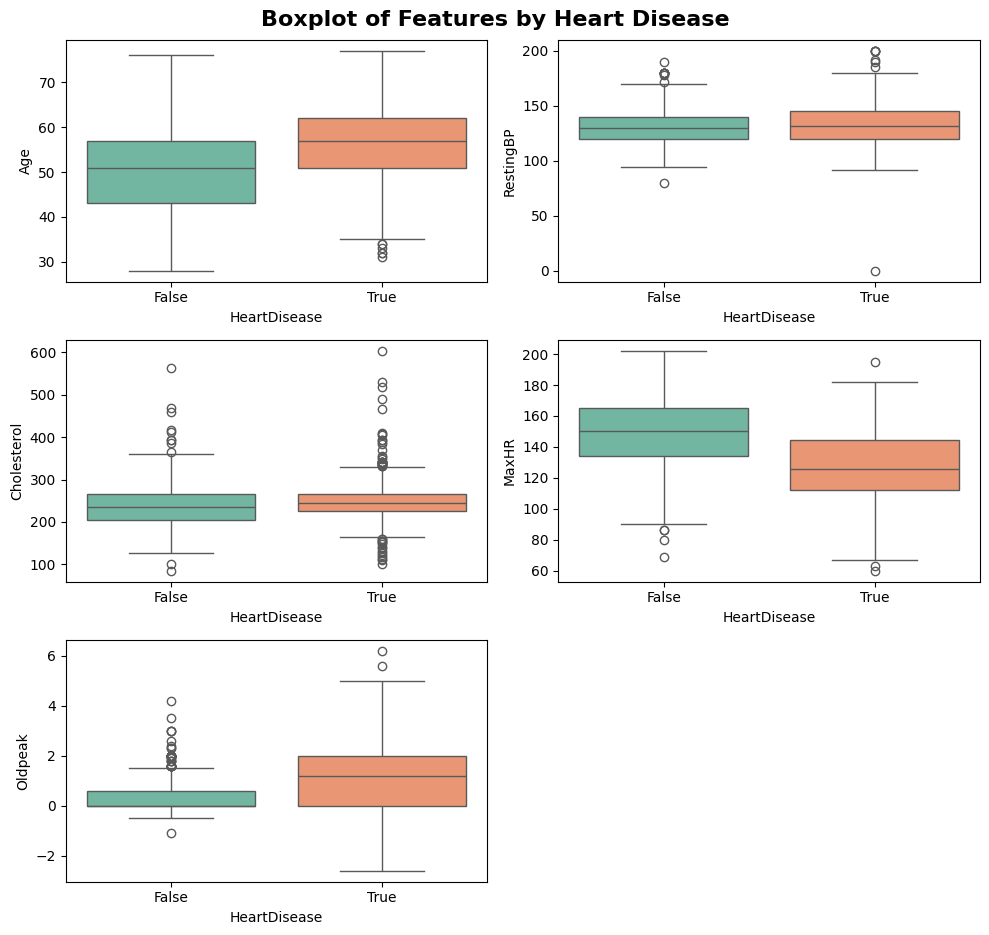

In [61]:
# Boxplot delle feature in relazione a Heart Disease
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Boxplot of Features by Heart Disease', fontsize=16, weight='bold', y=0.93)

for i in num_features:
    ax = fig.add_subplot(3, 2, num_features.index(i) + 1)
    sns.boxplot(x='HeartDisease', y=i, data=df, palette='Set2')

    plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

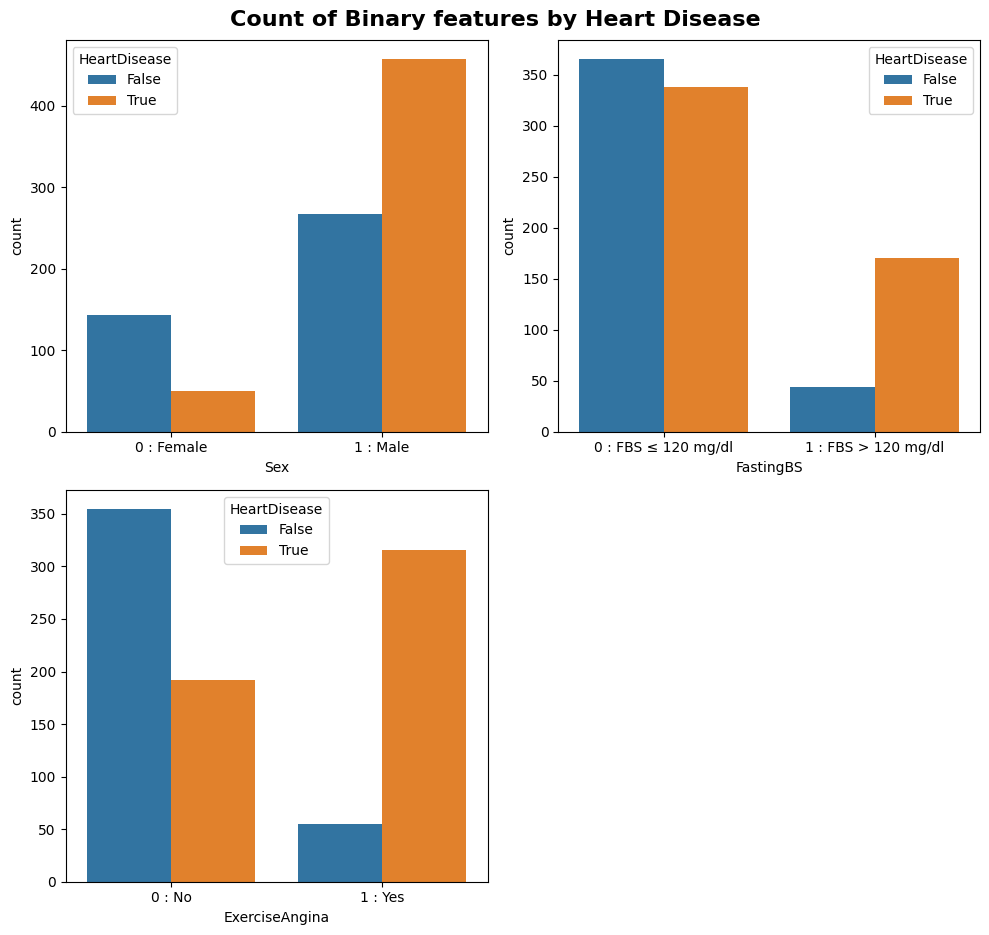

In [62]:
# Plot delle feature binarie in relazione a Heart Disease

# Dizionario per le etichette descrittive
labels_dict = {
    'Sex': {0: '0 : Female', 1: '1 : Male'},
    'FastingBS': {0: '0 : FBS ≤ 120 mg/dl', 1: '1 : FBS > 120 mg/dl'},
    'ExerciseAngina': {0: '0 : No', 1: '1 : Yes'}
}

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Count of Binary features by Heart Disease', fontsize=16, weight='bold', y=0.93)

for i, feature in enumerate(bin_features):
    ax = plt.subplot(2, 2, i+1)
    sns.countplot(x= df[feature] , hue = df['HeartDisease'])
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Modifica le etichette dell'asse x con le descrizioni
    if feature in labels_dict:
        ax.set_xticklabels([labels_dict[feature][int(label.get_text())] 
                           for label in ax.get_xticklabels()])
plt.show()

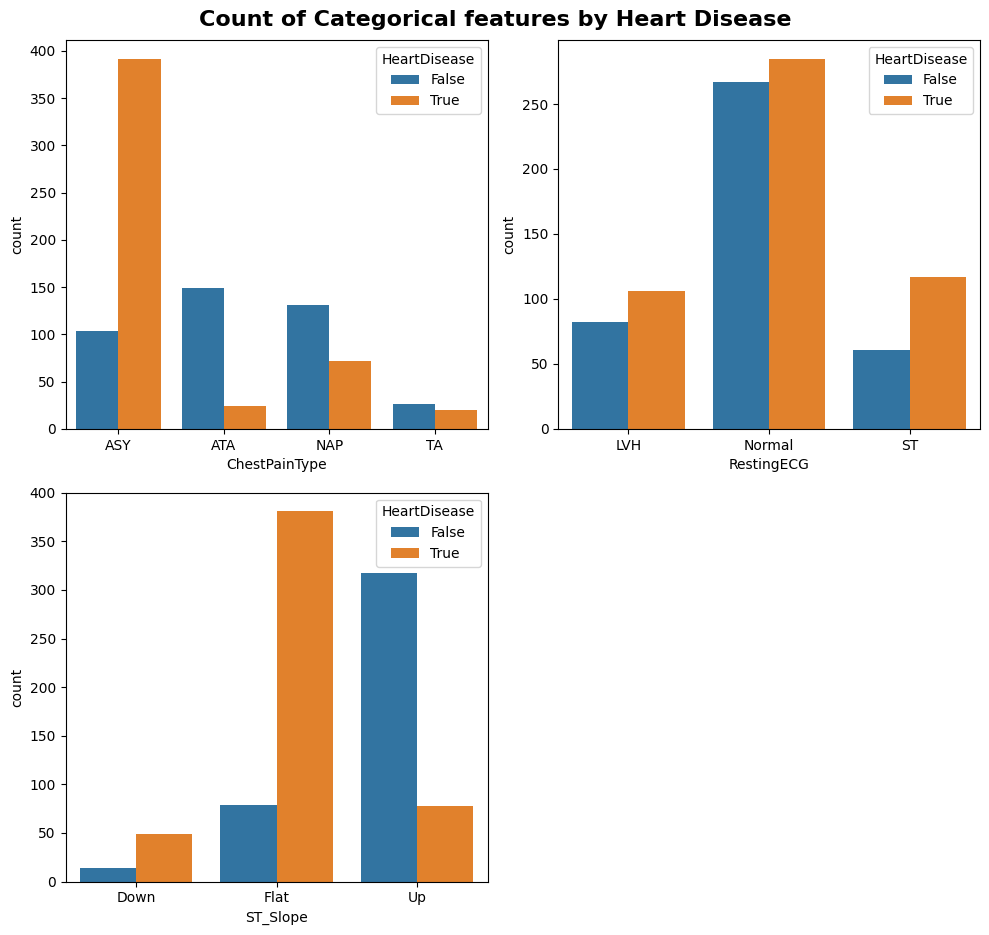

In [63]:
# Plot delle feature categoriche in relazione a Heart Disease
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Count of Categorical features by Heart Disease', fontsize=16, weight='bold', y=0.93)

for i in cat_features:
    ax = plt.subplot(2, 2, cat_features.index(i)+1)
    sns.countplot(x= df[i] , hue = df['HeartDisease'])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

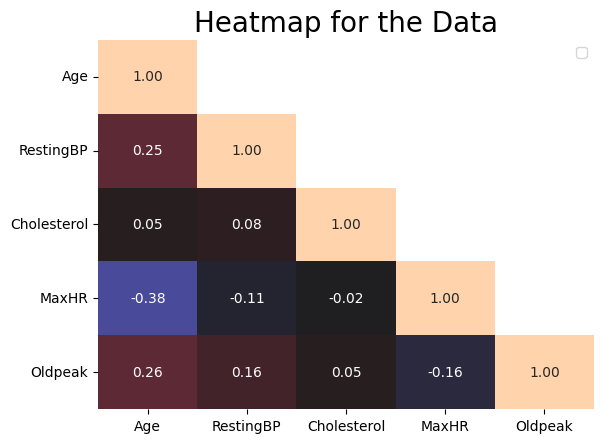

In [64]:
# Heatmap correlations
sns.heatmap(df[num_features].corr(),
            center=0,
            annot=True,
            fmt='.2f',
            mask=~np.tri(df[num_features].corr().shape[1], dtype=bool),
            cbar=False)

plt.title('Heatmap for the Data', fontsize = 20)
plt.legend()
plt.show()

In [65]:
# save the cleaned dataset
df_clean.to_csv('heart_cleaned.csv', index=False)
print("Cleaned dataset saved as 'heart_cleaned.csv'.")

Cleaned dataset saved as 'heart_cleaned.csv'.


## Principal Component Analysis

Trasformiamo i dati affinchè i dati abbiano scale omogenee.

In [66]:
import joblib

# Normalizzazione dei dati
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[num_features])
scaled_data

# Salvataggio del modello di scaling
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

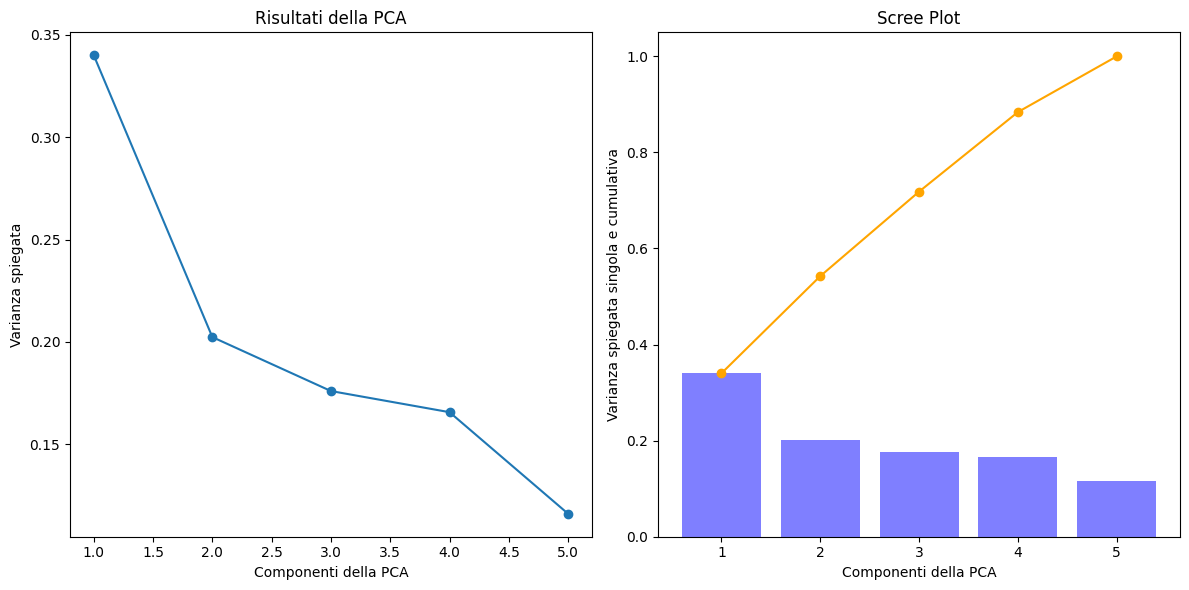

['pca.joblib']

In [67]:
pca = PCA().fit(scaled_data)

# Grafico varianza spiegata per ogni componente
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")

# Calcola la varianza spiegata cumulativa e crea lo scree plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1, 2, 2)
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.5, align='center')
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata singola e cumulativa')
plt.title("Scree Plot")

plt.tight_layout()
plt.show()

joblib.dump(pca, 'pca.joblib')

In [68]:
# PCA per vedere quante feature spiegano il 90% di varianza
pca_data = PCA(0.90).fit_transform(scaled_data)
pca_data.shape

(918, 5)

In [69]:
# # PCA per vedere quanta varianza è spiegata da 4 feature
# pca_data = PCA(n_components=4).fit(scaled_data)
# pca_data.explained_variance_ratio_.sum()

In [70]:
# Creazione tabella autovalore, percentuale varianza e percentuale varianza cumulativa
eigen_values = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_ratio = variance_ratio.cumsum()

pca_results = pd.DataFrame({
    'Eigenvalue': eigen_values,
    'Variance Percent': variance_ratio,
    'Cumulative Variance Percent': cumulative_ratio
})
pca_results.index = ['Component ' + str(i+1) for i in pca_results.index]

pca_results

,Eigenvalue,Variance Percent,Cumulative Variance Percent
Component 1,1.702267,34.008252,34.008252
Component 2,1.012787,20.233682,54.241934
Component 3,0.880805,17.596920,71.838853
Component 4,0.829078,16.563507,88.402360
Component 5,0.580514,11.597640,100.000000


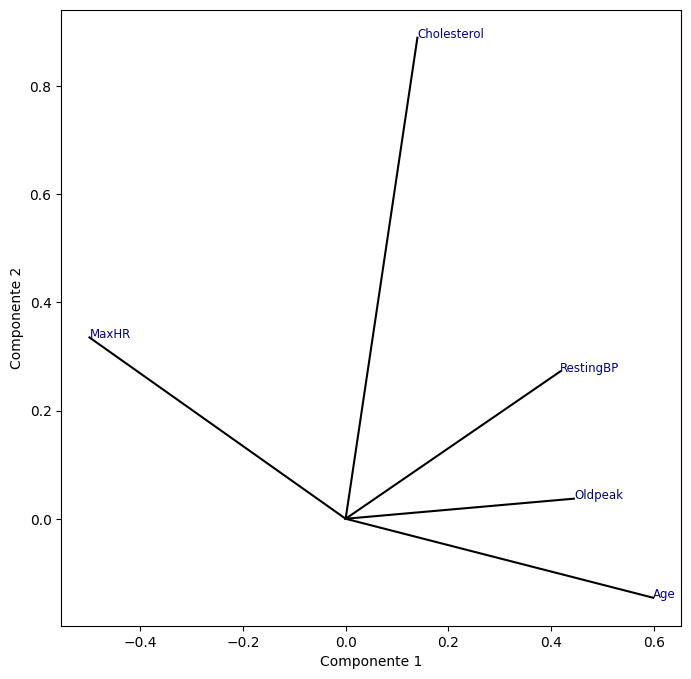

In [71]:
# Grafico che mostra la correlazione delle variabili
pcs = pca.components_
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.plot([0, x], [0, y], color='k')
    ax.text(x, y, num_features[i], fontsize=8.5, color='darkblue')

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

plt.show()

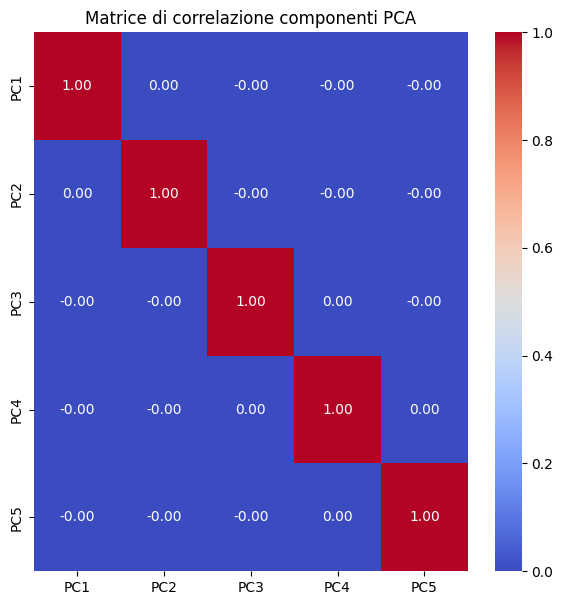

In [72]:
# Conferma del fatto che le componenti della PCA non sono correlate
correlation_matrix = np.corrcoef(pca_data, rowvar=False)

plt.figure(figsize=(7,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"],
            yticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"])
plt.title('Matrice di correlazione componenti PCA')
plt.show()

# Models

# DECISION TREE

In [73]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

In [74]:
# funzione per calcolare le metriche e salvarle in un dizionario

all_metrics = []

def calculate_metrics(y_test, y_pred, model_name, approach):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

In [75]:
timing_collector = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}

In [76]:
# Creazione del dataset pronto per i modelli
df_clean['FastingBS'] = df_clean['FastingBS'].astype(int)

X, y = df_clean.drop('HeartDisease', axis=1), df_clean['HeartDisease']

# Split in Train e Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
df_clean.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180.0,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283.0,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214.0,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195.0,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [78]:
# Creazione e addestramento del modello Decision Tree
clf = DecisionTreeClassifier(random_state=300)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

In [79]:
print(f'tempo training albero di decisione naive in secondi: {training_time:.4f}')
timing_collector['dt_naive_training'] = training_time

tempo training albero di decisione naive in secondi: 0.0042


In [80]:
accuracy_train_list = []
accuracy_train = clf.score(X_train, y_train)
accuracy_train_list.append(accuracy_train)
print(f'Accuracy di training: {accuracy_train:.4f}')

Accuracy di training: 1.0000


In [81]:
# Predizioni sul test set
y_pred = clf.predict(X_test)

print("misure di performance albero di decisione a livello di classe:\n")
print(classification_report(y_test, y_pred))

misure di performance albero di decisione a livello di classe:

              precision    recall  f1-score   support

       False       0.67      0.82      0.74        77
        True       0.84      0.71      0.77       107

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.75       184
weighted avg       0.77      0.76      0.76       184



In [82]:
# Raggruppamento delle principali metriche di valutazione
dt_naive_metrics = calculate_metrics(y_test, y_pred, 'Decision Tree', 'Naive')
all_metrics.append(dt_naive_metrics)


Misure di performance globali decision tree naive

Accuracy: 0.7554347826086957
Precision: 0.8444444444444444
Recall: 0.7102803738317757
F1-score: 0.7715736040609137


Text(0.5, 81.72222222222219, 'Label Predetta')

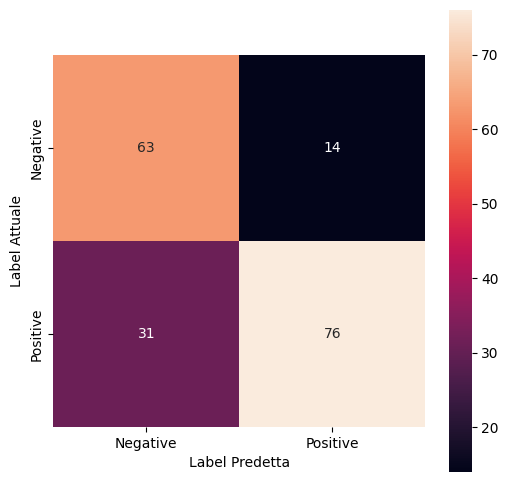

In [83]:
    # Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Negative', 'Positive'],
                        yticklabels=['Negative', 'Positive'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta')

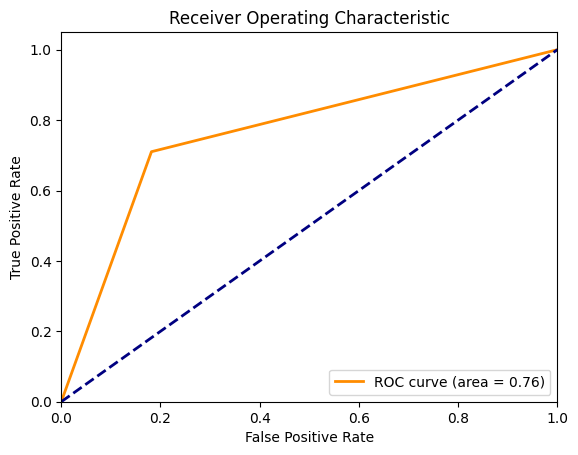

In [84]:
# Curva Roc
# Probabilità della classe positiva (HeartDisease=1)
y_prob = clf.predict_proba(X_test)[:, 1]

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcola l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Traccia la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

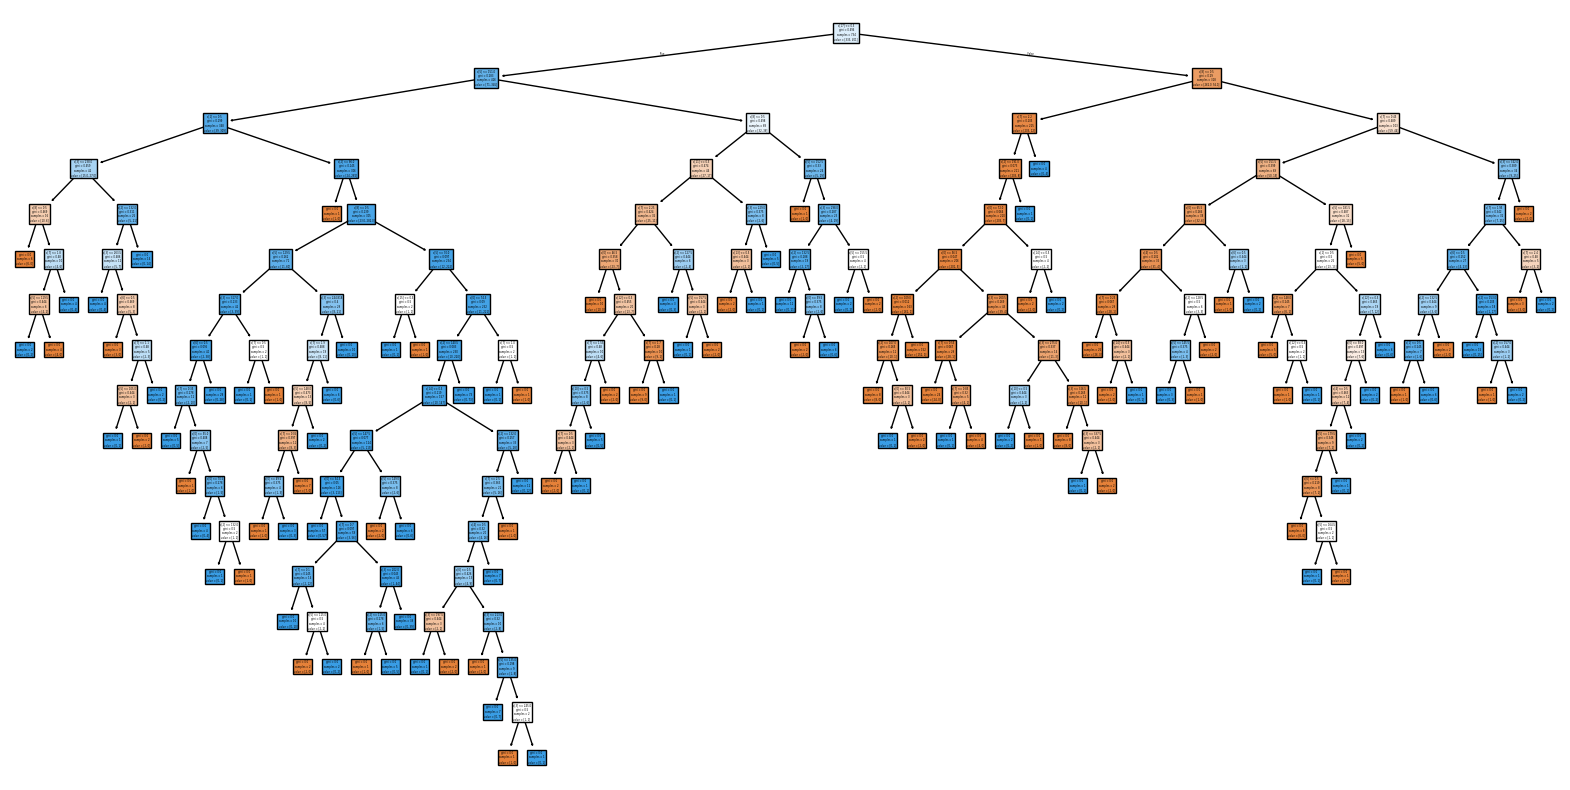

In [85]:
# Visualizzazione dell'albero di decisione
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True)
plt.show()

In [86]:
# Definizione della griglia di parametri
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.1]
}

# Grid Search con validazione incrociata
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

# Migliori parametri trovati
print("Migliori parametri:", grid_search.best_params_)

joblib.dump(grid_search.best_params_, 'best_decision_tree_model.pkl')

# Creazione dell'albero con i migliori parametri
best_dt = grid_search.best_estimator_

Migliori parametri: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'splitter': 'random'}


In [87]:
print(f'tempo calcolo iperparametri ottimali con grid search in secondi: {training_time:.4f}')
timing_collector['dt_hyperparameter'] = training_time

tempo calcolo iperparametri ottimali con grid search in secondi: 1.0024


In [88]:
start_time = time.time()
best_dt.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

In [89]:
print(f'tempo training albero di decisione ottimale in secondi: {training_time:.4f}')
timing_collector['dt_optimal_training'] = training_time

tempo training albero di decisione ottimale in secondi: 0.0098


In [90]:
accuracy_train = best_dt.score(X_train, y_train)
print(f'Accuracy di training: {accuracy_train:.4f}')

Accuracy di training: 0.8706


In [91]:
# Predizioni sul test set
y_pred = best_dt.predict(X_test)

print("Misure di performance albero di decisione ottimizzato a livello di classe:\n")
print(classification_report(y_test, y_pred))

Misure di performance albero di decisione ottimizzato a livello di classe:

              precision    recall  f1-score   support

       False       0.77      0.74      0.75        77
        True       0.82      0.84      0.83       107

    accuracy                           0.80       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.80      0.80       184



In [92]:
# calcolo delle metriche di valutazione per albero di decisione ottimizzato
dt_optimal_metrics = calculate_metrics(y_test, y_pred, 'Decision Tree', 'Optimized')
all_metrics.append(dt_optimal_metrics)


Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


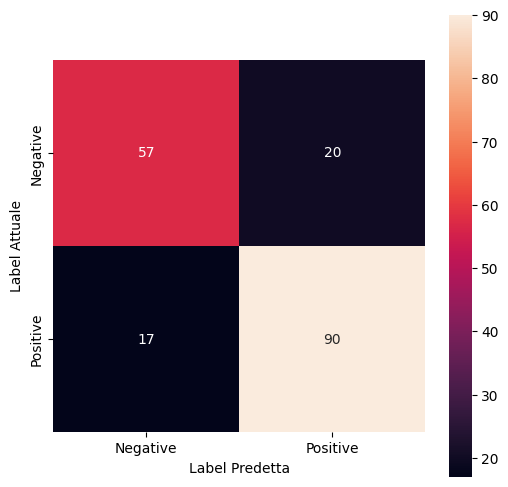

In [93]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Negative', 'Positive'],
                        yticklabels=['Negative', 'Positive'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

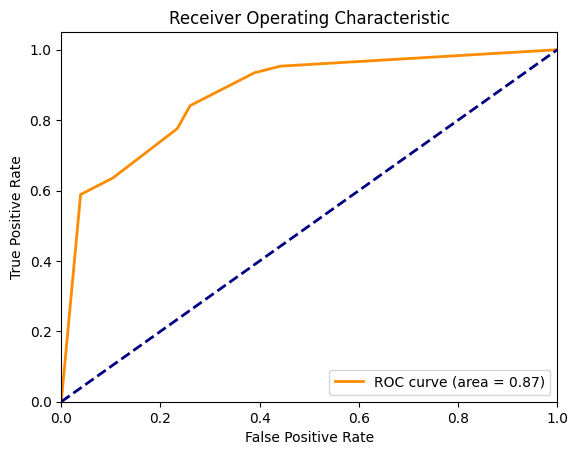

In [94]:
# Curva Roc
# Probabilità della classe positiva (HeartDisease=1)
y_prob = best_dt.predict_proba(X_test)[:, 1]

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calcola l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Traccia la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

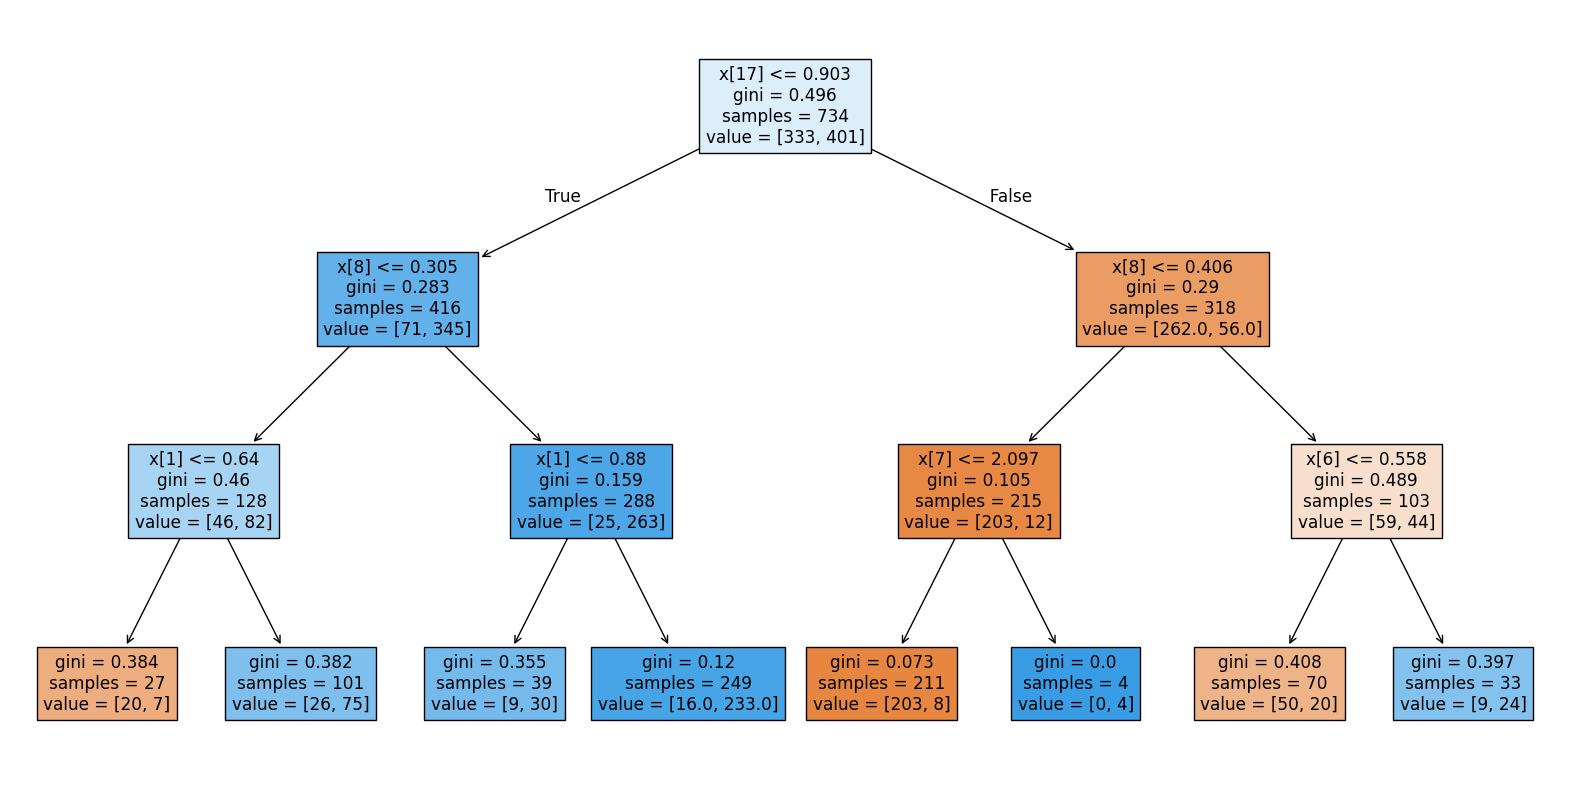

In [95]:
# Plot dell'albero di decisione ottimizzato
plt.figure(figsize=(20,10))  # Imposta la dimensione della figura
plot_tree(best_dt, filled=True)
plt.show()




```
# Questo è formattato come codice
```

# SVM Classifier

In [96]:
# Normalizzazione dei dati importante per SVM e reti neurali
df_clean[num_features] = scaler.fit_transform(df_clean[num_features])

X, y = df_clean.drop('HeartDisease', axis=1), df_clean['HeartDisease']

# Split in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [97]:
# Addestramento del Support Vector classifier
clf = svm.SVC(kernel='rbf', random_state=42, C=1000000)

start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

In [98]:
print(f'tempo training SVM naive in secondi: {training_time:.4f}')
timing_collector['svm_naive_training'] = training_time

tempo training SVM naive in secondi: 0.0139


In [99]:
accuracy_train = clf.score(X_train, y_train)
print(f'Accuracy di training: {accuracy_train:.4f}')

Accuracy di training: 1.0000


In [100]:
# Effettua le predizioni sul test set
y_pred = clf.predict(X_test)

print("Misure di performance support vector machines a livello di classe:\n")
print(classification_report(y_test, y_pred))

Misure di performance support vector machines a livello di classe:

              precision    recall  f1-score   support

       False       0.71      0.74      0.73        77
        True       0.81      0.79      0.80       107

    accuracy                           0.77       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.77      0.77       184



In [101]:
# calcolo metriche di valutazione per SVM naive
svm_naive_metrics = calculate_metrics(y_test, y_pred, 'SVM', 'Naive')
all_metrics.append(svm_naive_metrics)

Misure di performance globali svm naive

Accuracy: 0.7663043478260869
Precision: 0.8076923076923077
Recall: 0.7850467289719626
F1-score: 0.7962085308056872


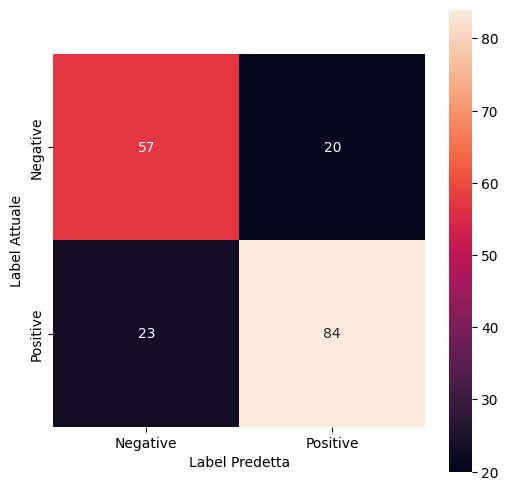

In [102]:
# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d',cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

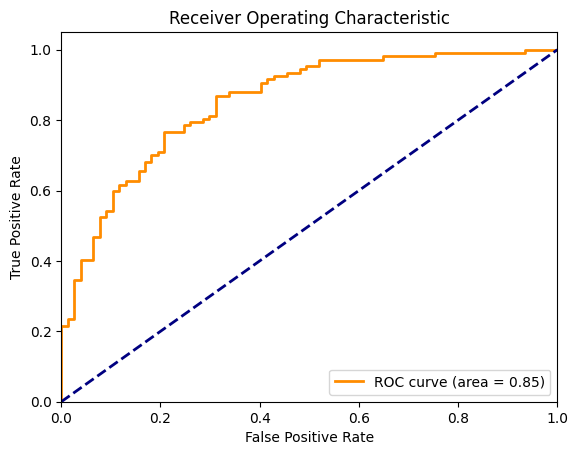

In [103]:
# Calcola le probabilità di predizione del modello
prob_svm = svm.SVC(kernel='rbf', random_state=42, C=1000000, probability=True)
prob_svm.fit(X_train, y_train)
y_pred_prob = prob_svm.predict_proba(X_test)[:, 1]

# Calcola la curva ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC (Area Under the Curve)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Traccia la curva ROC
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [104]:
# Tuning degli iperparametri C, kernel e gamma
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001, 0.00001],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [0.01, 0.001, 0.0001, 0.00001],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]

# Con la grid search ottimizzo l'accuracy
grid = GridSearchCV(svm.SVC(random_state=42), tuned_parameters, verbose=3, scoring='accuracy')

start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.551 total time=   0.0s
[CV 2/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.544 total time=   0.0s
[CV 3/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.544 total time=   0.0s
[CV 4/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.544 total time=   0.0s
[CV 5/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.548 total time=   0.0s
[CV 1/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.551 total time=   0.0s
[CV 2/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.544 total time=   0.0s
[CV 3/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.544 total time=   0.0s
[CV 4/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.544 total time=   0.0s
[CV 5/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.548 total time=   0.0s
[CV 1/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.551 total time=   0.0s
[CV 2/5] END .C=0.001, gamma=0.0001, kernel=rbf

In [105]:
print(f'tempo calcolo iperparametri ottimali con grid search in secondi: {training_time:.4f}')
timing_collector['svm_hyperparameter'] = training_time

tempo calcolo iperparametri ottimali con grid search in secondi: 13.7241


In [106]:
# Stampa degli iperparametri ottimali
print("Iperparametri ottimali:", grid.best_params_)

Iperparametri ottimali: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [107]:
# Addestramento del modello con iperparametri ottimali e calcolo del tempo di addestramento
svm_optimal_model = svm.SVC(**grid.best_params_, random_state=42)
start_time = time.time()
estimator_svm_optimal = svm_optimal_model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

In [108]:
print(f'tempo calcolo SVM ottimale in secondi: {training_time:.4f}')
timing_collector['svm_optimal_training'] = training_time

tempo calcolo SVM ottimale in secondi: 0.0121


In [109]:
accuracy_train = estimator_svm_optimal.score(X_train, y_train)
print(f'Accuracy di training: {accuracy_train:.4f}')

Accuracy di training: 0.9087


In [110]:
# Valutazione del modello con classification report sklearn
y_pred_optimal = estimator_svm_optimal.predict(X_test)

print("Misure di performance support vector machines ottimizzato a livello di classe:\n")
print(classification_report(y_test, y_pred_optimal))

Misure di performance support vector machines ottimizzato a livello di classe:

              precision    recall  f1-score   support

       False       0.84      0.81      0.82        77
        True       0.86      0.89      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



In [111]:
# Calcolo delle metriche di valutazione per SVM ottimizzato
svm_optimal_metrics = calculate_metrics(y_test, y_pred_optimal, 'SVM', 'Optimized')
all_metrics.append(svm_optimal_metrics)

Misure di performance globali svm optimized

Accuracy: 0.8532608695652174
Precision: 0.8636363636363636
Recall: 0.8878504672897196
F1-score: 0.8755760368663594


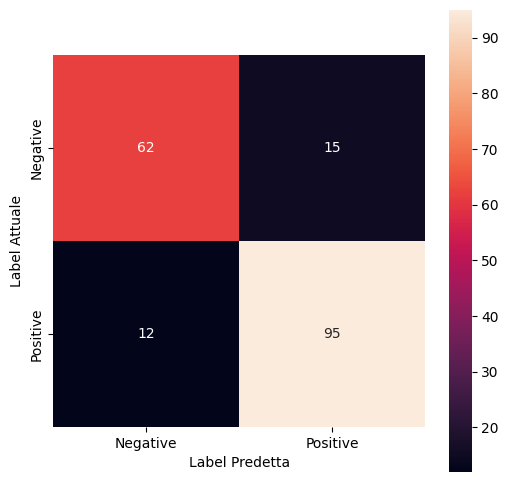

In [112]:
# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_optimal)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

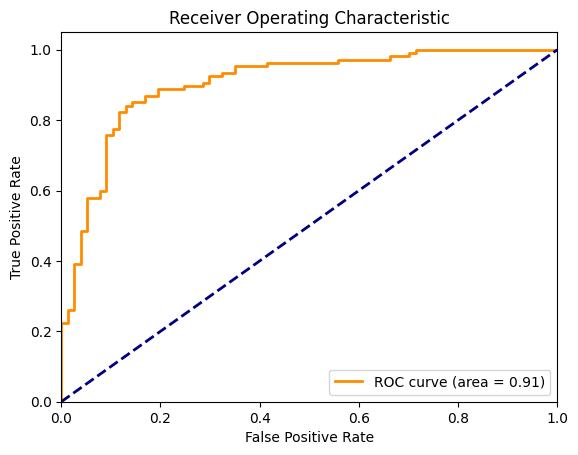

In [113]:
# Calcola le probabilità di predizione del modello
prob_svm_optimal_model = svm.SVC(**grid.best_params_, random_state=42, probability=True)
prob_svm_optimal_model.fit(X_train, y_train)
y_pred_optimal_prob = prob_svm_optimal_model.predict_proba(X_test)[:, 1]

# Calcola la curva ROC
fpr_svm_opt, tpr_svm_opt, _ = roc_curve(y_test, y_pred_optimal_prob)

# Calcola l'AUC (Area Under the Curve)
roc_auc_svm_opt = auc(fpr_svm_opt, tpr_svm_opt)

# Traccia la curva ROC
plt.figure()
plt.plot(fpr_svm_opt, tpr_svm_opt, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm_opt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# NEURAL NETWORK

In [114]:
%pip install numpy tensorflow scikit-learn scikeras


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [115]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

In [116]:
# Creazione del modello
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),  # Primo strato nascosto
    Dense(50, activation='relu'),  # Secondo strato nascosto
    Dense(1, activation='sigmoid')  # Output layer per classificazione binaria
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Addestramento del modello
start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7602 - loss: 0.5771 - val_accuracy: 0.8098 - val_loss: 0.4869
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8365 - loss: 0.4184 - val_accuracy: 0.8315 - val_loss: 0.4158
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3606 - val_accuracy: 0.8370 - val_loss: 0.3981
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8706 - loss: 0.3324 - val_accuracy: 0.8315 - val_loss: 0.3911
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8719 - loss: 0.3169 - val_accuracy: 0.8424 - val_loss: 0.3830
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.3039 - val_accuracy: 0.8424 - val_loss: 0.3813
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8842 - loss: 0.2964 - val_accuracy: 0.8370 - val_loss: 0.3811
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8896 - loss: 0.2882 - val_accuracy: 0.8315 - val_loss:

In [117]:
print(f'tempo training rete neurale naive in secondi: {training_time:.4f}')
timing_collector['nn_naive_training'] = training_time

tempo training rete neurale naive in secondi: 3.9154


In [118]:
# Recupero della loss e dell'accuracy dal training
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]

# Stampa dei risultati
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Loss: 0.1051
Training Accuracy: 0.9714


In [119]:
# Predizioni sul test set
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

# Valutazione delle performance
print("Misure di performance rete neurale a livello di classe:\n")
print(classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Misure di performance rete neurale a livello di classe:

              precision    recall  f1-score   support

       False       0.85      0.75      0.80        77
        True       0.84      0.91      0.87       107

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



In [120]:
# calcolo delle metriche di valutazione per rete neurale naive
nn_naive_metrics = calculate_metrics(y_test, y_pred, 'Neural Network', 'Naive')
all_metrics.append(nn_naive_metrics)

Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


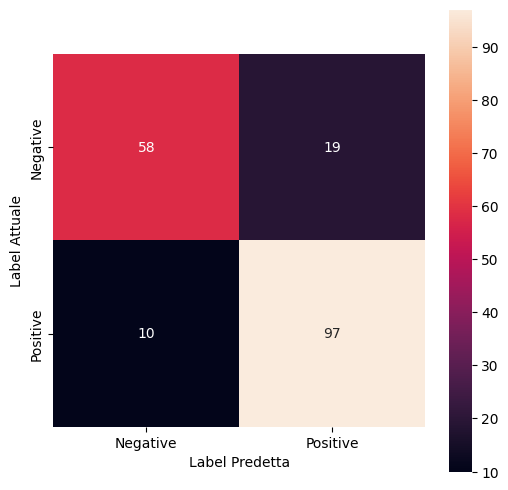

In [121]:
# Creazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Negative', 'Positive'],
                        yticklabels=['Negative', 'Positive'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

In [122]:
# Valutazione del modello sui dati di test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Stampa dei risultati
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8424 - loss: 0.5970 
Test Loss: 0.5970
Test Accuracy: 0.8424


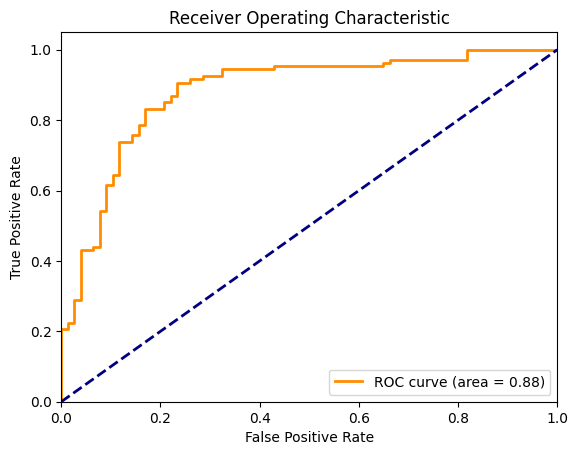

In [123]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plottare la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [124]:
# Funzione per costruire il modello
def build_model(hidden_layer_sizes=(100,), activation='relu', optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0], activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))

    # Aggiunge più livelli nascosti se specificati
    for units in hidden_layer_sizes[1:]:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))

    # Livello di output con attivazione sigmoide per classificazione binaria
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creazione del wrapper Keras con build_fn
clf = KerasClassifier(
    build_fn=build_model,
    verbose=0,
    optimizer="adam",
    activation="relu",
    hidden_layer_sizes=(100,),
    epochs=100,
    batch_size=32,
    dropout_rate=0.2
)

# Creazione della pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', clf)
])

# Definizione della griglia di parametri (corretta)
param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,)],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam'],
    'model__epochs': [50, 100],
    'model__batch_size': [16, 32],
    'model__dropout_rate': [0.2, 0.3]
}

# Grid Search con pipeline
start_time = time.time()
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

# Migliori parametri trovati
print("Migliori parametri:", grid_search.best_params_)

Migliori parametri: {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.3, 'model__epochs': 100, 'model__hidden_layer_sizes': (100,), 'model__optimizer': 'adam'}


In [125]:
print(f'tempo calcolo iperparametri ottimali con grid search in secondi: {training_time:.4f}')
timing_collector['nn_hyperparameter'] = training_time

tempo calcolo iperparametri ottimali con grid search in secondi: 101.5990


In [126]:
# Estrai i migliori parametri trovati
best_params = grid_search.best_params_
activation = best_params['model__activation']
batch_size = best_params['model__batch_size']
epochs = best_params['model__epochs']
hidden_layer_sizes = best_params['model__hidden_layer_sizes']
optimizer = best_params['model__optimizer']

selected_optimizer = optimizers.get(optimizer)

# Definizione del modello con i migliori parametri trovati
model = Sequential([
    Dense(hidden_layer_sizes[0], activation=activation, input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')  # Sigmoid per output probabilità
])

# Compilazione del modello
model.compile(optimizer=selected_optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])

# Addestramento con i migliori parametri
start_time = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
end_time = time.time()
training_time = end_time - start_time

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8161 - loss: 0.5248 - val_accuracy: 0.8315 - val_loss: 0.4722
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8420 - loss: 0.4288 - val_accuracy: 0.8152 - val_loss: 0.4222
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.3832 - val_accuracy: 0.8152 - val_loss: 0.4040
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8583 - loss: 0.3588 - val_accuracy: 0.8152 - val_loss: 0.3971
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.3429 - val_accuracy: 0.8370 - val_loss: 0.3918
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3328 - val_accuracy: 0.8370 - val_loss: 0.3903
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3247 - val_accuracy: 0.8370 - val_loss: 0.3881
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8747 - loss: 0.3189 - val_accuracy: 0.8370 - v

In [127]:
print(f'tempo training rete neurale ottimizzata in secondi: {training_time:.4f}')
timing_collector['nn_optimal_training'] = training_time

tempo training rete neurale ottimizzata in secondi: 5.6262


In [128]:
# Recupero della loss e dell'accuracy dal training
train_loss = history.history['loss'][-1]  # Ultimo valore della loss in training
train_accuracy = history.history['accuracy'][-1]  # Ultimo valore della accuracy in training

# Stampa dei risultati
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Loss: 0.1863
Training Accuracy: 0.9264


In [129]:
# Predizioni
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

# Report di classificazione
print("misure di performance rete neurale ottimizzata a livello di classe:\n")
print(classification_report(y_test, y_pred))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
misure di performance rete neurale ottimizzata a livello di classe:

              precision    recall  f1-score   support

       False       0.83      0.81      0.82        77
        True       0.86      0.88      0.87       107

    accuracy                           0.85       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



In [130]:
# Raggruppamento delle principali metriche di valutazione
nn_optimal_metrics = calculate_metrics(y_test, y_pred, 'Neural Network', 'Optimized')
all_metrics.append(nn_optimal_metrics)

Misure di performance globali neural network optimized

Accuracy: 0.8478260869565217
Precision: 0.8623853211009175
Recall: 0.8785046728971962
F1-score: 0.8703703703703703


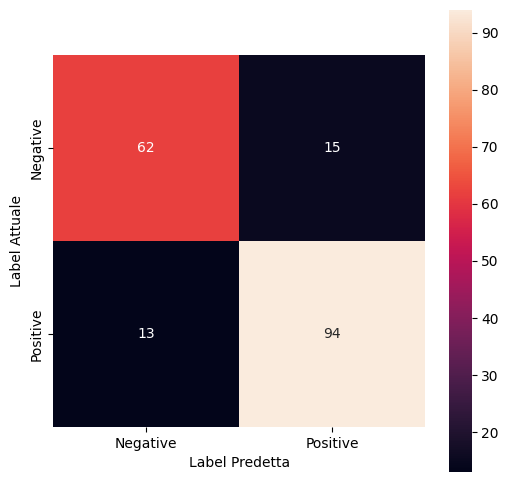

In [131]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive']
           )
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta')
plt.show()

In [132]:
# Valutazione del modello sui dati di test
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Stampa dei risultati
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8478 - loss: 0.4115 
Test Loss: 0.4115
Test Accuracy: 0.8478


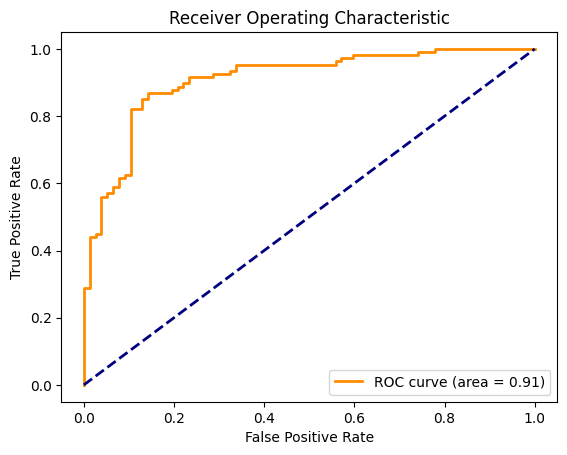

In [133]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [134]:
def create_comprehensive_comparison_plots(all_metrics):
    """
    Create comprehensive comparison plots for all models
    """
    # Convert to DataFrame
    df_metrics = pd.DataFrame(all_metrics)
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Side-by-side comparison (Naive vs Optimized)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ML Models Performance Comparison: Naive vs Optimized', fontsize=16, fontweight='bold')
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = df_metrics['model'].unique()
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        
        # Separate naive and optimized data
        naive_data = df_metrics[df_metrics['approach'] == 'Naive']
        opt_data = df_metrics[df_metrics['approach'] == 'Optimized']
        
        x = np.arange(len(models))
        width = 0.35
        
        naive_values = [naive_data[naive_data['model'] == model][metric].values[0] 
                       for model in models]
        opt_values = [opt_data[opt_data['model'] == model][metric].values[0] 
                     for model in models]
        
        bars1 = ax.bar(x - width/2, naive_values, width, label='Naive', alpha=0.8, color='lightcoral')
        bars2 = ax.bar(x + width/2, opt_values, width, label='Optimized', alpha=0.8, color='lightblue')
        
        ax.set_xlabel('Models')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=0)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [135]:
def create_actual_timing_plots(timing_collector):
    """
    Create timing comparison plots using actual collected data with log scale,
    arranged in 2 rows: 2 plots on top, 1 on bottom.
    """
    # Create timing DataFrame
    timing_data = {
        'Algorithm': ['Decision Tree', 'Decision Tree', 'SVM', 'SVM', 'Neural Network', 'Neural Network'],
        'Approach': ['Naive', 'Optimized', 'Naive', 'Optimized', 'Naive', 'Optimized'],
        'Training_Time': [
            timing_collector['dt_naive_training'],
            timing_collector['dt_optimal_training'],
            timing_collector['svm_naive_training'], 
            timing_collector['svm_optimal_training'],
            timing_collector['nn_naive_training'],
            timing_collector['nn_optimal_training']
        ],
        'Hyperparameter_Time': [
            0,
            timing_collector['dt_hyperparameter'],
            0,
            timing_collector['svm_hyperparameter'], 
            0,
            timing_collector['nn_hyperparameter']
        ]
    }
    
    df_timing = pd.DataFrame(timing_data)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ML Algorithms Timing Performance Analysis - Actual Results (Log Scale)', fontsize=16, fontweight='bold')

    models = df_timing['Algorithm'].unique()
    x = np.arange(len(models))
    width = 0.35

    # 1. Training Time Comparison (top-left)
    ax1 = axes[0, 0]
    naive_training = [df_timing[(df_timing['Algorithm'] == model) & 
                                (df_timing['Approach'] == 'Naive')]['Training_Time'].values[0] 
                      for model in models]
    opt_training = [df_timing[(df_timing['Algorithm'] == model) & 
                              (df_timing['Approach'] == 'Optimized')]['Training_Time'].values[0] 
                    for model in models]
    
    bars1 = ax1.bar(x - width/2, naive_training, width, label='Naive', alpha=0.8, color='lightcoral')
    bars2 = ax1.bar(x + width/2, opt_training, width, label='Optimized', alpha=0.8, color='lightblue')
    
    ax1.set_xlabel('Algorithms')
    ax1.set_ylabel('Training Time (seconds)')
    ax1.set_title('Training Time Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both')

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height * 1.1,
                 f'{height:.4f}s', ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height * 1.1,
                 f'{height:.4f}s', ha='center', va='bottom', fontsize=9)

    # 2. Hyperparameter Optimization Time (top-right)
    ax2 = axes[0, 1]
    hyperparameter_times = [df_timing[(df_timing['Algorithm'] == model) & 
                                      (df_timing['Approach'] == 'Optimized')]['Hyperparameter_Time'].values[0] 
                            for model in models]

    bars = ax2.bar(models, hyperparameter_times, alpha=0.8, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_xlabel('Algorithms')
    ax2.set_ylabel('Hyperparameter Optimization Time (seconds)')
    ax2.set_title('Hyperparameter Optimization Time')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, which='both')

    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height * 1.1,
                     f'{height:.2f}s', ha='center', va='bottom', fontsize=10)

    # 3. Total Time Investment (bottom-left)
    ax3 = axes[1, 0]
    total_times_opt = [opt_training[i] + hyperparameter_times[i] for i in range(len(models))]

    bars1 = ax3.bar(x - width/2, naive_training, width, label='Naive Total', alpha=0.8, color='lightcoral')
    bars2 = ax3.bar(x + width/2, opt_training, width, label='Optimized Training', alpha=0.8, color='lightblue')
    bars3 = ax3.bar(x + width/2, hyperparameter_times, width, bottom=opt_training, 
                    label='Hyperparameter Time', alpha=0.8, color='lightgreen')
    
    ax3.set_xlabel('Algorithms')
    ax3.set_ylabel('Total Time (seconds)')
    ax3.set_title('Total Time Investment')
    ax3.set_xticks(x)
    ax3.set_xticklabels(models)
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3, which='both')

    # Hide the unused subplot (bottom-right)
    axes[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the suptitle
    plt.show()

    return df_timing

In [136]:
%pip install tabulate


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [137]:
from tabulate import tabulate

def create_comprehensive_summary_table(all_metrics):
    """
    Create comprehensive summary tables with detailed analysis using tabulate
    """
    df_metrics = pd.DataFrame(all_metrics)
    
    print("\n" + "="*120)
    print("COMPREHENSIVE PERFORMANCE SUMMARY TABLES")
    print("="*120)
    
    # 1. Main Performance Table
    print("\n MAIN PERFORMANCE TABLE")
    print("-" * 50)
    
    models = df_metrics['model'].unique()
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    
    summary_data = []
    for model in models:
        naive_data = df_metrics[(df_metrics['model'] == model) & (df_metrics['approach'] == 'Naive')]
        opt_data = df_metrics[(df_metrics['model'] == model) & (df_metrics['approach'] == 'Optimized')]
        
        if not naive_data.empty and not opt_data.empty:
            row = [model]
            for metric in metrics:
                naive_val = naive_data[metric].values[0]
                opt_val = opt_data[metric].values[0]
                row.extend([f"{naive_val:.4f}", f"{opt_val:.4f}"])
            summary_data.append(row)
    
    headers = ['Model']
    for metric in metrics:
        headers.extend([f'{metric.title()}_Naive', f'{metric.title()}_Optimized'])
    
    print(tabulate(summary_data, headers=headers, tablefmt='fancy_grid', stralign='center'))
    
    # 2. Improvements Table
    print("\n IMPROVEMENTS TABLE (Optimized - Naive)")
    print("-" * 50)
    
    improvements_data = []
    for model in models:
        naive_data = df_metrics[(df_metrics['model'] == model) & (df_metrics['approach'] == 'Naive')]
        opt_data = df_metrics[(df_metrics['model'] == model) & (df_metrics['approach'] == 'Optimized')]
        
        if not naive_data.empty and not opt_data.empty:
            row = [model]
            total_improvement = 0
            
            for metric in metrics:
                naive_val = naive_data[metric].values[0]
                opt_val = opt_data[metric].values[0]
                improvement = opt_val - naive_val
                total_improvement += improvement
                
                sign = "+" if improvement >= 0 else ""
                row.append(f"{sign}{improvement:.4f}")
            
            row.append(f"{total_improvement/len(metrics):+.4f}")
            improvements_data.append(row)
    
    improvement_headers = ['Model'] + [metric.replace("_", " ").title() for metric in metrics] + ['Average']
    print(tabulate(improvements_data, headers=improvement_headers, tablefmt='fancy_grid', stralign='center'))
    
    # 3. Ranking Tables
    print("\n MODEL RANKINGS")
    print("-" * 30)
    
    for approach in ['Naive', 'Optimized']:
        print(f"\n{approach} Models Ranking:")
        approach_data = df_metrics[df_metrics['approach'] == approach].copy()
        
        rankings_data = []
        for metric in metrics:
            sorted_data = approach_data.sort_values(metric, ascending=False)
            row = [metric.replace('_', ' ').title()]
            
            for i, (_, model_row) in enumerate(sorted_data.iterrows(), 1):
                row.append(f"{model_row['model']} ({model_row[metric]:.4f})")
            
            rankings_data.append(row)
        
        num_models = len(approach_data)
        ranking_headers = ['Metric'] + [f'{i}°' for i in range(1, num_models + 1)]
        
        print(tabulate(rankings_data, headers=ranking_headers, tablefmt='fancy_grid', stralign='left'))
    
    # 4. Best vs Worst Performance Table
    print("\n BEST vs WORST PERFORMANCE ANALYSIS")
    print("-" * 45)
    
    performance_analysis = []
    for metric in metrics:
        naive_subset = df_metrics[df_metrics['approach'] == 'Naive']
        opt_subset = df_metrics[df_metrics['approach'] == 'Optimized']
        
        best_naive = naive_subset.loc[naive_subset[metric].idxmax()]
        best_opt = opt_subset.loc[opt_subset[metric].idxmax()]
        
        worst_naive = naive_subset.loc[naive_subset[metric].idxmin()]
        worst_opt = opt_subset.loc[opt_subset[metric].idxmin()]
        
        analysis_row = [
            metric.replace('_', ' ').title(),
            f"{best_naive['model']} ({best_naive[metric]:.4f})",
            f"{best_opt['model']} ({best_opt[metric]:.4f})",
            f"{worst_naive['model']} ({worst_naive[metric]:.4f})",
            f"{worst_opt['model']} ({worst_opt[metric]:.4f})"
        ]
        performance_analysis.append(analysis_row)
    
    analysis_headers = ['Metric', 'Best_Naive', 'Best_Optimized', 'Worst_Naive', 'Worst_Optimized']
    print(tabulate(performance_analysis, headers=analysis_headers, tablefmt='fancy_grid', stralign='center'))
    
    # Return DataFrames
    summary_df = pd.DataFrame(summary_data, columns=headers).set_index('Model')
    improvements_df = pd.DataFrame(improvements_data, columns=improvement_headers).set_index('Model')
    ranking_df = pd.DataFrame(rankings_data, columns=ranking_headers).set_index('Metric')
    analysis_df = pd.DataFrame(performance_analysis, columns=analysis_headers).set_index('Metric')
    
    return summary_df, improvements_df, ranking_df, analysis_df


In [138]:
def run_all_comparisons():
    """
    Run all comparison analyses
    """
    print("Generating comprehensive model comparison plots...")
    
    # 1. Main comparison plots
    create_comprehensive_comparison_plots(all_metrics)

    # 2. Timing comparison plots
    create_actual_timing_plots(timing_collector)
    
    # 3. Performance evolution table
    create_comprehensive_summary_table(all_metrics)

    print("\nAnalysis complete! All comparison plots have been generated.")

Generating comprehensive model comparison plots...


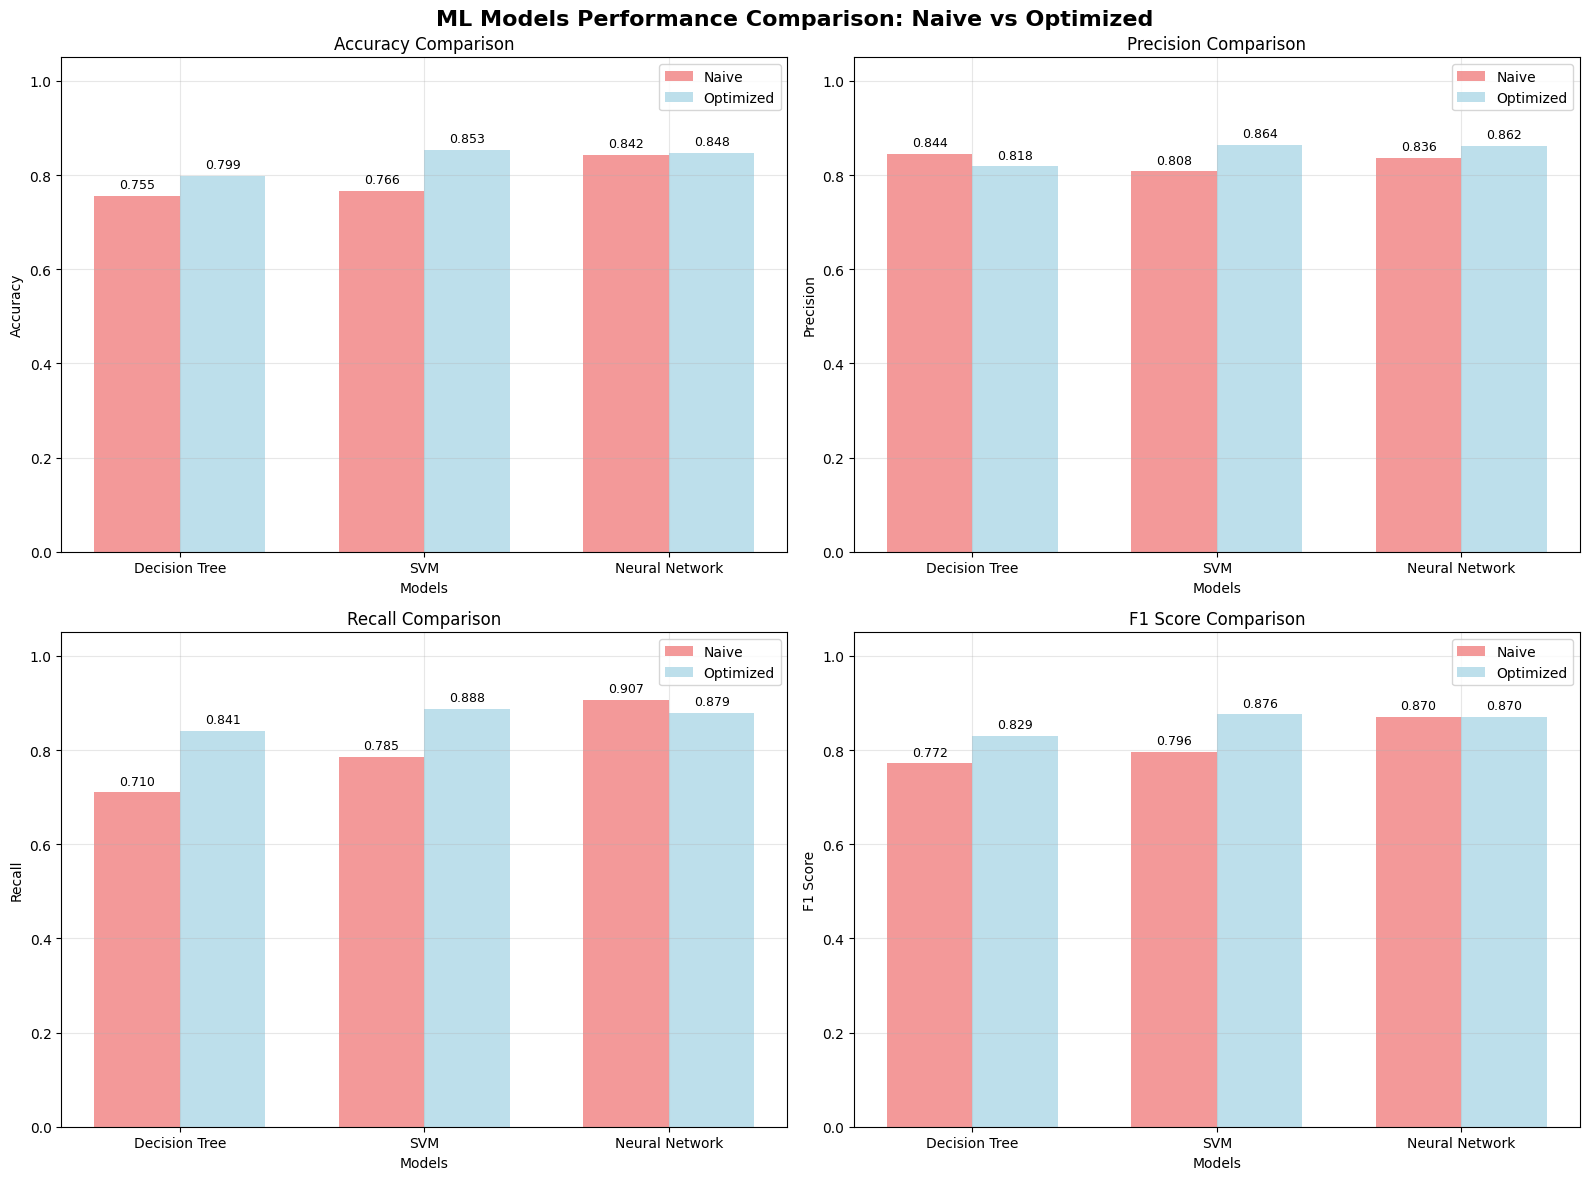

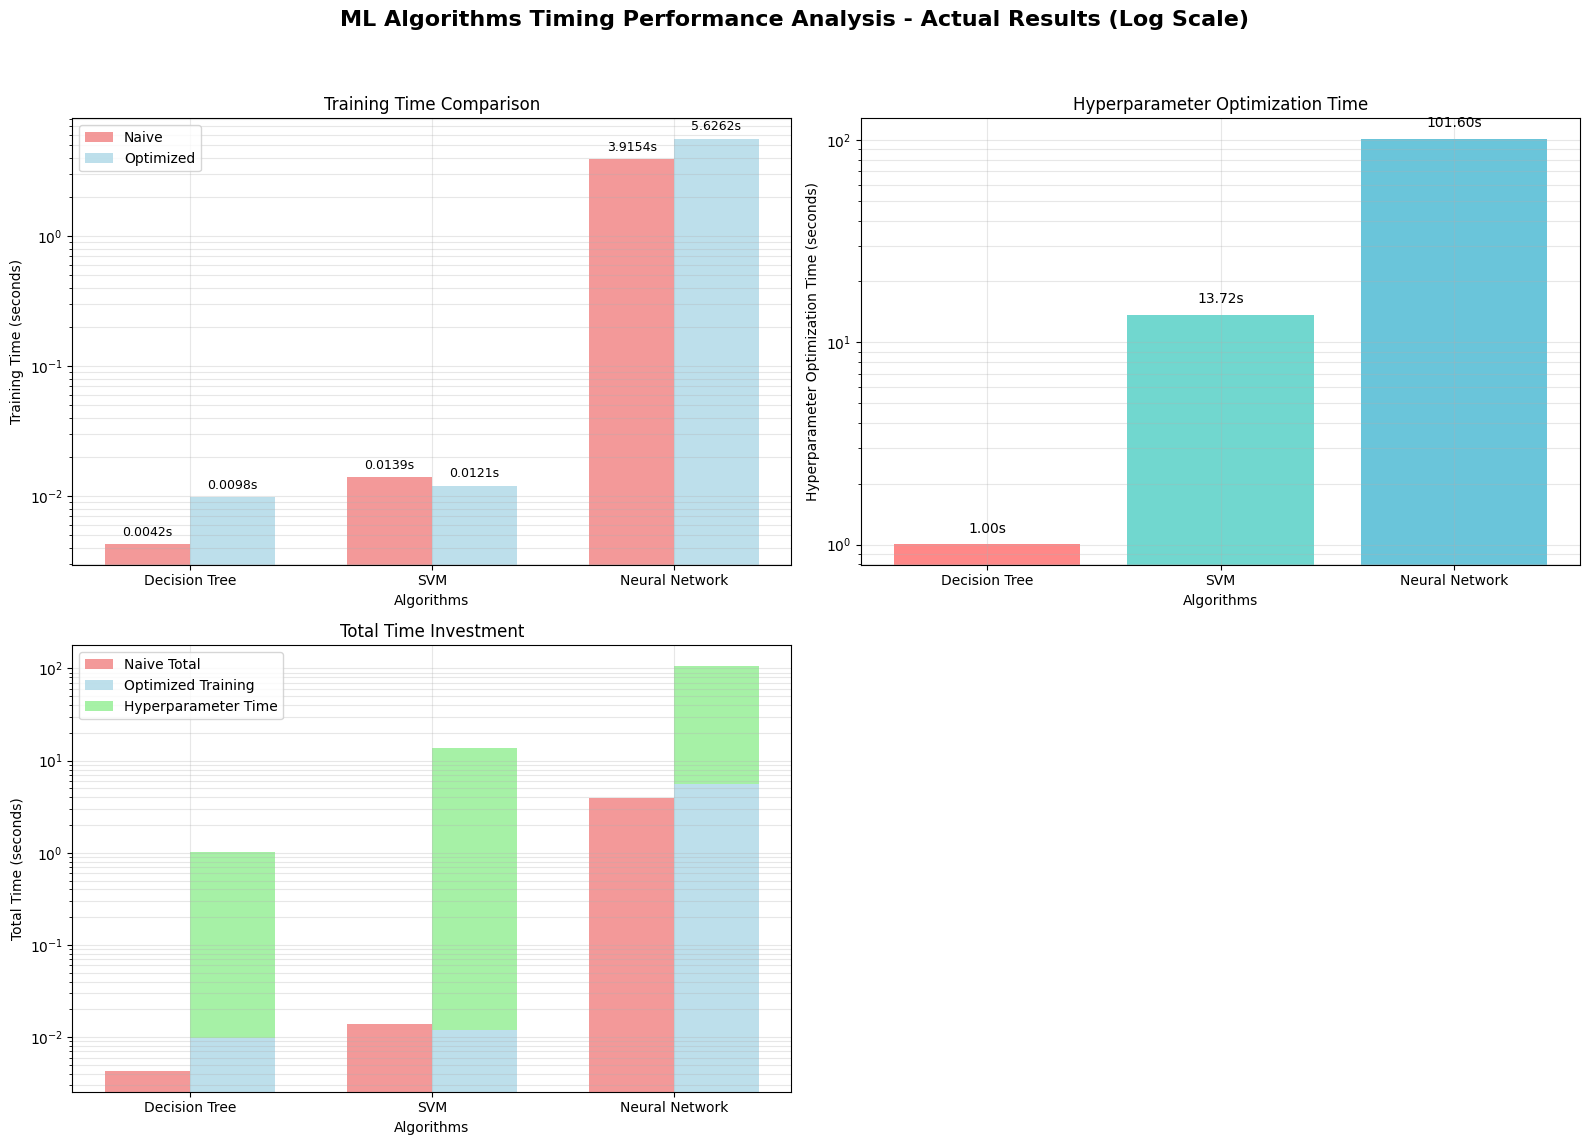


COMPREHENSIVE PERFORMANCE SUMMARY TABLES

 MAIN PERFORMANCE TABLE
--------------------------------------------------
╒════════════════╤══════════════════╤══════════════════════╤═══════════════════╤═══════════════════════╤════════════════╤════════════════════╤══════════════════╤══════════════════════╕
│     Model      │   Accuracy_Naive │   Accuracy_Optimized │   Precision_Naive │   Precision_Optimized │   Recall_Naive │   Recall_Optimized │   F1_Score_Naive │   F1_Score_Optimized │
╞════════════════╪══════════════════╪══════════════════════╪═══════════════════╪═══════════════════════╪════════════════╪════════════════════╪══════════════════╪══════════════════════╡
│ Decision Tree  │           0.7554 │               0.7989 │            0.8444 │                0.8182 │         0.7103 │             0.8411 │           0.7716 │               0.8295 │
├────────────────┼──────────────────┼──────────────────────┼───────────────────┼───────────────────────┼────────────────┼────────────────────┼

In [139]:
run_all_comparisons()